# Discrete Residues

In the previous post, we discussed a particular quantity, $\mathbb{P}\{X=1\}$, where $X$ follows a Poisson Binomial distribution, parameterized by $\{p_j\}_{j=1}^n$. This means that $X=\sum_jX_j$, where $X_j$ are Bernoulli-$p_j$ independent random variables.

We came up with an $O(1)$ memory and $O(n)$ time approach to computing the desired probability, and gave an example where even the best approximations can be poor.

What about a more general question? Let's take a look at what it takes to find $\xi_k=\mathbb{P}\{X=k\}$ for arbitrary $k$.

### Existing Approaches

The state-of-the-art here is an [FFT-based approach called DFT-CF](https://www.sciencedirect.com/science/article/abs/pii/S0167947312003568), which computes the characteristic function of $X$, $\phi(t)=G_X(e^{it})$. It turns out that the array $\xi_k=\mathbb{P}\{X=k\}$ is the DFT of $x_k=\phi\left(\frac{2\pi k}{n+1}\right)$. Note that computing $\{x_k\}$ is the most expensive part of this routine, taking quadratic time.

The above paper refers to RF1, which is the straightforward extension of the "coefficient list" approach from the previous post, shown here as a direct convolution by [whuber](https://stats.stackexchange.com/a/41263/37308). For some reason, the article author uses $O(n^2)$ space for RF1, but this is gratuitous.

Indeed, the coefficient list algorithm (henceforth, CL), requires $O(n)$ memory and $O(nk)$ time, computes $\{\xi_{k'}\}_{k'=1}^k$, and has the nice property of doing less work if $k$ is small, but in the worst case $k=n$ it's still very straightforward to understand. In particular, recall the definition of the PGF $G_X(t)=\mathbb{E}t^X$ from the previous post, which we can see satisfies $\xi_k=\mathbb{P}\{X=k\}=\frac{G^{(k)}_X(0)}{k!}$ by expanding the series $\mathbb{E}t^X$.

For our Poisson Binomial $X$, notice $G_X(t)=\prod_j(1-p_j(1-t))$ is a degree-$n$ polynomial, so its $k$-th coefficient is exactly $\frac{G^{(k)}_X(0)}{k!}=\xi_k$.

Now we can imagine $n$ variables $Y_j$ for $j\in[n]$, where $Y_j$ is Poisson Binomial with parameters $\{p_{j'}\}_{j'=1}^j$. Clearly $Y_n=X$ and $G_{Y_{j-1}}(t)(1-p_j(1-t))=G_{Y_j}(t)$. By the above observation, we only care about the lowest $k$ coefficients of the final answer. The product of two polynomials $G_{Y_{j-1}}(t)(1-p_j(1-t))$ is just the convolution of their coefficient lists, and if we only maintain the first $k$ coefficients of the accumulation term, the coefficient list of $(1-p_j(1-t))$ is just $[1-p_j, p_j]$, which is length two, and thus each multiplication requires $O(k)$ time.

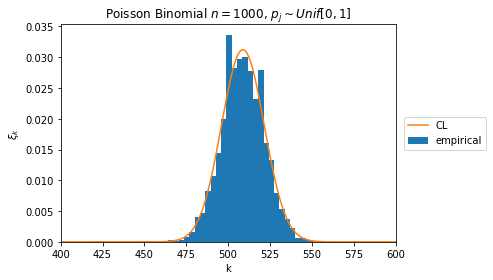

In [7]:
import numpy as np

np.random.seed(1234)
n = 1000
p = np.random.rand(n)
p.sort()

def shift(x, y):
    y[1:] = x[:-1]
    y[0] = 0

def cl(p, k):
    p = p.copy()
    p.sort()
    xi = np.zeros(k)
    xi[0] = 1
    xi2 = np.zeros(k)
    shift(xi, xi2)
    for pp in p:
        xi *= (1 - pp)
        xi += pp * xi2
        shift(xi, xi2)
    return xi

pmf = cl(p, 1001)
samples = 10 * 1000

samples = np.sum(np.random.rand(samples, len(p)) < p, axis=1)

%matplotlib inline
from matplotlib import pyplot as plt
plt.hist(samples, density=True, label='empirical', bins=30)
plt.plot(pmf, label='CL')
plt.legend(bbox_to_anchor=(1.01, 0.5), loc='center left')
plt.xlim(400, 600)
plt.xlabel("k")
plt.ylabel(r"$\xi_k$")
plt.title(r"Poisson Binomial $n=1000$, $p_j\sim Unif[0,1]$")
plt.show()

In [2]:
def dft_cf(p):
    n = len(p)
    phi = np.zeros(n + 1) + 0j
    phi[0] = 1
    for k in range(1, 1 + n // 2):
        phi[k] = np.prod((1 - p + p * np.exp(2j * np.pi * k / (n + 1))))
    phi[n // 2 + 1:] = np.conj(phi[n // 2:n % 2:-1])
    return np.fft.fft(phi / (n + 1)).real
    
np.allclose(dft_cf(p), cl(p, n + 1))

True

In [3]:
%%script Rscript --vanilla /dev/stdin

# poibin is the R package by the DFT-CF author
library(poibin)
set.seed(1234)

prev <- 1
for (i in 10:14) {
    n <- 2 ^ i
    tot <- 0
    for (j in 1:5) {
        p <- runif(n)
        ptm <- proc.time()
        invisible(dpoibin(kk=0:n, pp=p))
        ptm <- proc.time() - ptm
        ptm <- ptm["elapsed"]
        tot <- tot + ptm
    }
    ratio <- tot / prev
    prev <- tot
    
    write(sprintf("2^%2d %7.3f (%5.1fx prev)", i, prev / 5, ratio), file=stdout())
}

2^10   0.023 (  0.1x prev)
2^11   0.087 (  3.8x prev)
2^12   0.360 (  4.1x prev)
2^13   1.692 (  4.7x prev)
2^14   6.597 (  3.9x prev)


In [4]:
from time import time

def bench(f):
    np.random.seed(1234)
    prev = 1
    for i in range(10, 15):
        n = 2 ** i
        tot = 0
        for _ in range(5):
            p = np.random.rand(n)
            t = time()
            f(p)
            tot += time() - t
        ratio = tot / prev
        prev = tot
        print("2^{:2d} {:7.3f} ({:5.1f}x prev)".format(i, prev / 5, ratio))

print('CL')
bench(lambda p: cl(p, len(p) + 1))

print('DFT-CF')
bench(dft_cf)

CL
2^10   0.008 (  0.0x prev)
2^11   0.023 (  3.0x prev)
2^12   0.076 (  3.3x prev)
2^13   0.287 (  3.8x prev)
2^14   1.322 (  4.6x prev)
DFT-CF
2^10   0.011 (  0.1x prev)
2^11   0.034 (  3.1x prev)
2^12   0.128 (  3.8x prev)
2^13   0.694 (  5.4x prev)
2^14   4.377 (  6.3x prev)


OK, so that's pretty neat, the FFT paper's R code runs in quadratic time, neatly quadrupling in runtime for every doubling of input. The numpy versions are a bit noisier in their scaling but uniformly faster.

### What Else is There?

So, neat, looks like we have a straightforward way (CL) for dealing with Poisson Binomials, with a grand total of $O(n^2)$ time and $O(n)$ memory for the full PMF, and a specialization that the first $k$ terms $\{\xi_{k'}\}_{k'=1}^k$ can be computed in $O(nk)$ time and $O(k)$ memory.

What if I'm just interested in a single $\mathbb{P}\{X=k\}$ query? Is there a non-quadratic answer to this problem?

In particular, I might be interested in the inverse survival function, which for fixed $\alpha$ finds the smallest $k$ such that $\mathbb{P}\{X\ge k\}\le\alpha$. Sure, we can run the quadratic algorithms, but if we could answer queries quickly, say in $O(n)$ time and $O(1)$ memory, then the inverse survival function can be found quickly through binary search. This could be used for hypothesis testing, for instance.

We'll focus on Poisson Binomials but everything discussed here will apply to any discrete variables with analytic PGFs, and performance implications for answering queries will tend to be "quadratic to linear" if the discrete variable is an independent sum.

### Discrete Residues

Recall that for analytic $f$, Cauchy's integral formula tells us that

$$
\frac{f^{(k)}(0)}{k!}=\frac{1}{2\pi i}\oint_\gamma \frac{f(z)}{z^{k+1}}dz\,\,,
$$

for an appropriately-oriented closed curve $\gamma$ winding once around $0$. So all we have to do to get $\xi_k=\frac{G_X^{(k)}(0)}{k!}$ is to take the residue of the corresponding pole. To actually take an integral, keyboard to bits, we first convert it to a line integral with the parameterization around the unit circle $\gamma$ with $z=e^{i\theta}$:

$$
2\pi i\xi_k =\oint_\gamma\frac{f(z)}{z^{k+1}}dz =\int_{-\pi}^{\pi}iG_X(e^{i\theta})\exp(-ki\theta)d\theta\,\,.
$$

In [6]:
from scipy.integrate import fixed_quad, quad
import numpy as np
from numba import jit

def integrand(p):
    @jit("float64(float64, float64[:], float64)", nopython=True)
    def compiled_f(x, p, k):
        return np.real((
            # G_X(e^(ix))
            np.prod(1 - p * (1 - np.exp(1j * x)))
            # e^(-kix)
            * np.exp(1j * x * -k)
        ) / 2 / np.pi)
    def f(x, k):
        return compiled_f(x, p, k)
    return f

def query(p):
    f = integrand(p)
    def queryk(k):
        return quad(lambda x: f(x, k), -np.pi, np.pi)[0]
    return queryk


np.random.seed(1234)
n = 10000
p = np.random.rand(n)
p.sort()

queries = n // 2 - 1, n // 2, n // 2 + 1

t = time()
pmf = cl(p, len(p) + 1)
pmf_vals = [pmf[k] for k in queries]
cl_t = time() - t

q = query(p)
t = time()
q_vals = [q(k) for k in queries]
q_t = time() - t

print('cl time', cl_t)
print('q  time', q_t)
with np.printoptions(precision=5):
    print('cl vals', np.array(pmf_vals))
    print('q  vals', np.array(q_vals))

cl time 0.3863358497619629
q  time 0.15331459045410156
cl vals [0.00978 0.00979 0.00979]
q  vals [0.00978 0.00979 0.00979]


Note that above I just integrated

$$
\xi_k=\int_{-pi}^\pi\mathrm{Re}\,\frac{G_X(e^{i\theta})\exp(-ki\theta)}{2\pi}d\theta\,\,,
$$

directly, letting me use the adaptive quadrature routine. It may be cheating to say this is $O(n)$ time, since accurate quadrature may need more samples. Nonetheless, the example above demonstrates it's viable for large $n$ compared to the quadratic method.

Again, what's neat about discrete residues is that any analytic $G_X$ can be used, so it's not just specific to the Poisson Binomial.

That's it for the main technique. It's interesting to think about parallelization, both for the main CL method and for integration directly.